In [1]:
import pandas as pd
import configparser
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

## Fetch database login credentials
from the `dwh.cfg` file

In [2]:
config = configparser.ConfigParser()
config.read_file(open('dwh.cfg'))


DB_NAME = config.get('cluster_settings','db_name')
MASTER_USER_NAME = config.get('cluster_settings','master_user_name')
MASTER_USER_PASSWORD = config.get('cluster_settings','master_user_password')
PORT = config.get('cluster_settings','port')
ENDPOINT = config.get('cluster_settings','endpoint')

# connection string setup
conn = f'postgresql://{MASTER_USER_NAME}:{MASTER_USER_PASSWORD}@{ENDPOINT}:{PORT}/{DB_NAME}'

## Compare intersection of staging tables
by their "song/title" and "artist name" attributes.

In [3]:
# set up a dictionary to iterate over and retrieve database data
target_table_attribute = {
     'staging.events':['song','artist']
    ,'staging.songs':['title','artist_name']
}

# set up an empty dictionary to store data retrieval results
response_dict = {}

# first "lock in" target attributes to fetch data from
for counter in range(2):

    # then iterate over "table,attribute" pairs:
    for table, attribute in target_table_attribute.items():

        print('fetching data from:',table+'.'+attribute[counter])

        sql_query =f"""
            SELECT
                {attribute[counter]}
            FROM
                {table}
            WHERE
                {attribute[counter]} IS NOT NULL
        """

        # store data in the specified dictionary
        response_dict[table+'.'+attribute[counter]] = pd.read_sql(sql_query,conn).iloc[:,0].unique().tolist()
        
print('data retrieval finished.')

fetching data from: staging.events.song
fetching data from: staging.songs.title
fetching data from: staging.events.artist
fetching data from: staging.songs.artist_name
data retrieval finished.


## Intersection of Song Titles
in `songs` and `events` staging (raw data) tables.  
**Comparison is done by song title strings (`song_id` is not present in both raw data tables).**
> This explains the low number of matches when inserting data into the `fact_songplays` table.

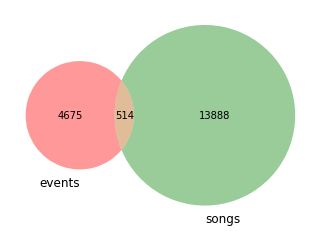

In [4]:
venn2( [set(response_dict['staging.events.song'])
       ,set(response_dict['staging.songs.title'])]
      ,set_labels=['events','songs']
     )

## Intersection of Artists
in both `songs` and `artists` staging (raw data) tables.  
**Comparison is done by artist name strings, and not by artist id's.**
> The reason for duplicate artist id's in the `dim_artist` dimension is given below.

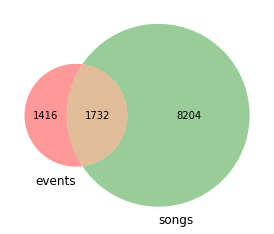

In [5]:
venn2([set(response_dict['staging.events.artist'])
     ,set(response_dict['staging.songs.artist_name'])]
    ,set_labels=['events','songs']
)

## Duplicate `artist_id`'s may happen
when a given song has the participation of another artist. Take a look at "Snoop Dog" below, for example.  
> Despite duplicate `artist_id`'s, **surrogate keys** (`artist_key` in this example) **will mantain their uniqueness**. Attributes having `key` in their name are dimension tables Primary Keys.

In [6]:
snoop_sql = """
    SELECT
        *
    FROM
        public.dim_artists
    WHERE
        artist_id = 'ARZ5H0P1187B98A1DD'
    ORDER BY
        artist_key
"""

snoop_frame = pd.read_sql(
     sql=snoop_sql
    ,con=conn
)

snoop_frame.head()

,artist_key,artist_id,name,location,latitude,longitude
0,567,ARZ5H0P1187B98A1DD,Snoop Dogg,"Long Beach, CA",33.76672,-118.1924
1,2949,ARZ5H0P1187B98A1DD,Snoop Dogg / Stevie Wonder,"Long Beach, CA",33.76672,-118.1924
2,5505,ARZ5H0P1187B98A1DD,Snoop Dogg Featuring Warren G_ Mauseburg And N...,"Long Beach, CA",33.76672,-118.1924
3,1223,ARZ5H0P1187B98A1DD,Snoop Dogg featuring Kid Cudi,"Long Beach, CA",33.76672,-118.1924


## Table row counts
for each table generated during this project:

In [7]:
# create a list of target tables
table_list = [
     'staging.events'
    ,'staging.songs'
    ,'public.dim_songs'
    ,'public.dim_artists'
    ,'public.dim_users'
    ,'public.dim_time'
    ,'public.fact_songplays'
]

# define sql query
metadata_sql ="""
    SELECT
         {table} AS record_source
        ,COUNT(*) AS row_count
    FROM
        {table}
"""

# create an empty DataFrame
metadata_frame = pd.DataFrame(columns=['source_table','row_count'])

for table in table_list:
    
    print('fetching data from:',table)
    
    data = pd.read_sql(
        sql=f"""
            SELECT
                 '{table}' AS source_table
                ,COUNT(*) AS row_count
            FROM
                {table}
        """
        ,con=conn
    )
    
    metadata_frame = metadata_frame.append(
         data
        ,ignore_index=True
        ,sort=False
    )
    

metadata_frame

fetching data from: staging.events
fetching data from: staging.songs
fetching data from: public.dim_songs
fetching data from: public.dim_artists
fetching data from: public.dim_users
fetching data from: public.dim_time
fetching data from: public.fact_songplays


,source_table,row_count
0,staging.events,8056
1,staging.songs,14896
2,public.dim_songs,14896
3,public.dim_artists,10025
4,public.dim_users,106
5,public.dim_time,8023
6,public.fact_songplays,322


## User subscription level history as Type 2 SCD
User subscription level changes over time are modeled with Type 2 Slowly Changing Dimension technique:  
* each change in this attribute triggers the insertion of a new row (with a new surrogate key for the user) in the table.  
* these attributes receive timestamps indicating the timespan during which they are valid.  
  
This enables precise analysis of what signature level a user had when he/she listened to a given song, for example.  
  
Take a look at user_id 15, "Lily" for example:

In [8]:
sql_subscription_timespan = """
    SELECT
         user_key
        ,user_id
        ,first_name
        ,"level"
        ,level_valid_since
        ,level_valid_until
        ,is_current_user_level
        
        -- subscription validity timespan is calculated
        ,CASE
            WHEN
                is_current_user_level = FALSE
            THEN
                level_valid_until - level_valid_since
            ELSE
                DATE_TRUNC('second',CURRENT_TIMESTAMP) - level_valid_since
        END AS time_spent_at_subscription_option
    FROM
        public.dim_users
    WHERE
        user_id = 15
    ORDER BY
        level_valid_since
"""

df_subscription_timespan = pd.read_sql(
     sql=sql_subscription_timespan
    ,con=conn
)

df_subscription_timespan.head()

,user_key,user_id,first_name,level,level_valid_since,level_valid_until,is_current_user_level,time_spent_at_subscription_option
0,1,15,Lily,paid,2018-11-02 09:01:21+00:00,2018-11-21 11:08:57+00:00,False,19 days 02:07:36
1,9,15,Lily,free,2018-11-21 11:08:57+00:00,2018-11-21 11:13:32+00:00,False,0 days 00:04:35
2,17,15,Lily,paid,2018-11-21 11:13:32+00:00,9999-12-31 23:59:59+00:00,True,500 days 07:58:19


## Songplays per User Gender
below we see there are much more songplays for Female than Male users on the Sparkify platform.

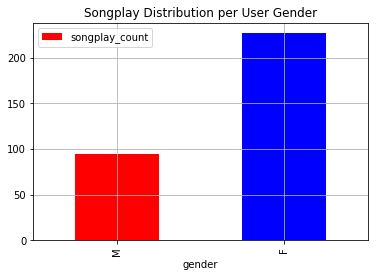

In [9]:
sql_gender_songplays = """
    SELECT
         dim_users.gender
        ,COUNT(1) AS songplay_count
    FROM
        public.fact_songplays AS fact_songplays
    INNER JOIN
        public.dim_users AS dim_users
    ON
        fact_songplays.user_key = dim_users.user_key
    GROUP BY
        dim_users.gender
"""

df_gender_songplays = pd.read_sql(
    sql=sql_gender_songplays
    ,con=conn
)

df_gender_songplays.plot(
     kind='bar'
    ,x='gender'
    ,y='songplay_count'
    ,color=['r','b']
    ,title='Songplay Distribution per User Gender'
    ,grid=True
)

## Users' actual subscription option
Distribution of `free` and `paid` subscriptions

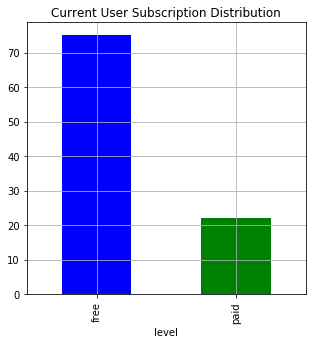

In [10]:
sql_subscription_option = """
    SELECT
         "level"
        ,COUNT("level") AS level_count
    FROM
        public.dim_users
    WHERE
        is_current_user_level = TRUE
    GROUP BY
        "level"
"""

df_subscription_option = pd.read_sql(
     sql=sql_subscription_option
    ,con=conn
)

df_subscription_option.plot(
     kind='bar'
    ,y='level_count'
    ,x='level'
    ,figsize=(5,5)
    ,color=['b','g']
    ,title='Current User Subscription Distribution'
    ,legend=False
    ,grid=True
)

## Users' gender distribution
There are more Female than Male users.  
This explains the distribution of songplays per gender we've previously seen.

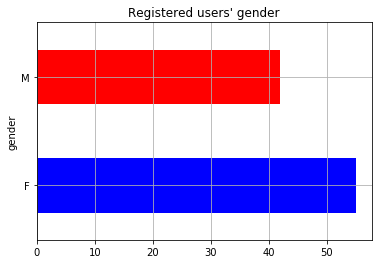

In [13]:
sql_users_gender = """
    SELECT
         gender
        ,COUNT(1) AS gender_count
    FROM
        public.dim_users
    WHERE
        is_current_user_level = TRUE
    GROUP BY
        gender
"""

df_users_gender = pd.read_sql(
     sql_users_gender
    ,con=conn
)

df_users_gender.plot(
     kind='barh'
    ,x='gender'
    ,y='gender_count'
    ,color=['b','r']
    ,grid=True
    ,legend=False
    ,title="Registered users' gender"
)

## `Looking Forward`: write three queries
to retrieve the possible combinations of values in columns going to be used for Parquet files partition in the next module's project `Data Lakes with Spark`.  
  
In the first query we see the `year` and `artist` partitioning scheme will generate more than 12 thousand partitions for the `dim_songs` table.

In [16]:
yearArtistCombinationsQuery = """
    SELECT
        COUNT(*) AS year_and_artist_combinations
    FROM(
        SELECT DISTINCT
             songs.year
            ,artists.artist_id
        FROM
            public.dim_artists AS artists
        INNER JOIN
            public.dim_songs AS songs
        ON
            artists.artist_id = songs.artist_id
    )
"""

dfYearArtistCombinations = pd.read_sql(
     con=conn
    ,sql=yearArtistCombinationsQuery
)

# exhibit query results below
dfYearArtistCombinations.head()

,year_and_artist_combinations
0,12620


In [19]:
yearMonthCombinationsQuery = """
    SELECT
        COUNT(*) AS year_and_month_combinations
    FROM(
        SELECT DISTINCT
             year
            ,month
        FROM
            public.dim_time
    )
"""

dfYearMonthCombinations = pd.read_sql(
     sql=yearMonthCombinationsQuery
    ,con=conn
)

# exhibit query results below
dfYearMonthCombinations.head()

,year_and_month_combinations
0,1


In [22]:
songplayYearMonthCombinationsQuery = """
    SELECT
        COUNT(*) AS songplays_year_month_combinations
    FROM(
        SELECT DISTINCT
             time.year
            ,time.month
        FROM
            public.fact_songplays AS songplays
        INNER JOIN
            public.dim_time AS time
        ON
            songplays.start_time = time.start_time
    )    
"""

dfSongplayYearMonthCombinations = pd.read_sql(
     sql=songplayYearMonthCombinationsQuery
    ,con=conn
)

# exhibit query results below
dfSongplayYearMonthCombinations.head()

,songplays_year_month_combinations
0,1
